In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from mongo import Mongo
import plotly.express as px

price_repo = Mongo(db='trading_bot', collection='stock_price')
month_revenue_repo = Mongo(db='trading_bot', collection='month_revenue')
balance_sheet_repo = Mongo(db='trading_bot', collection='balance_sheet')
income_sheet_repo = Mongo(db='trading_bot', collection='income_sheet')
cash_flow_repo = Mongo(db='trading_bot', collection='cash_flow')

price_data = price_repo.get_data_by_stock_id('1101')
# month_revenue_data = month_revenue_repo.get_data_by_stock_id('1101')
# income_sheet = income_sheet_repo.get_data_by_stock_id('1101')
# balance_sheet = balance_sheet_repo.get_data_by_stock_id('1101')
# cash_flow = cash_flow_repo.get_data_by_stock_id('1101')
# all_price_data = price_repo.get_all_data()
# all_month_revenue_data = month_revenue_repo.get_all_data()
# all_income_sheet = income_sheet_repo.get_all_data()
# all_balance_sheet = balance_sheet_repo.get_all_data()
# all_cash_flow = cash_flow_repo.get_all_data()

In [5]:
price_data[-5:]

,Timestamp,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover
10482,NaN,1101,15558263,545619542,35.10,35.20,35.00,35.10,0.00,6491
10483,NaN,1101,11373215,396932524,35.10,35.15,34.80,34.80,-0.30,9980
10484,2023-09-20,1101,27453105,948085087,34.80,34.85,34.35,34.35,-0.45,12561
10485,2023-09-21,1101,35756361,1216822304,34.25,34.25,33.80,33.80,-0.55,21386
10486,2023-09-22,1101,23534572,787453536,33.50,33.60,33.35,33.50,-0.30,16288


29        True
30       False
31       False
32       False
33       False
         ...  
10482    False
10483    False
10484    False
10485    False
10486     True
Name: close, Length: 10458, dtype: bool

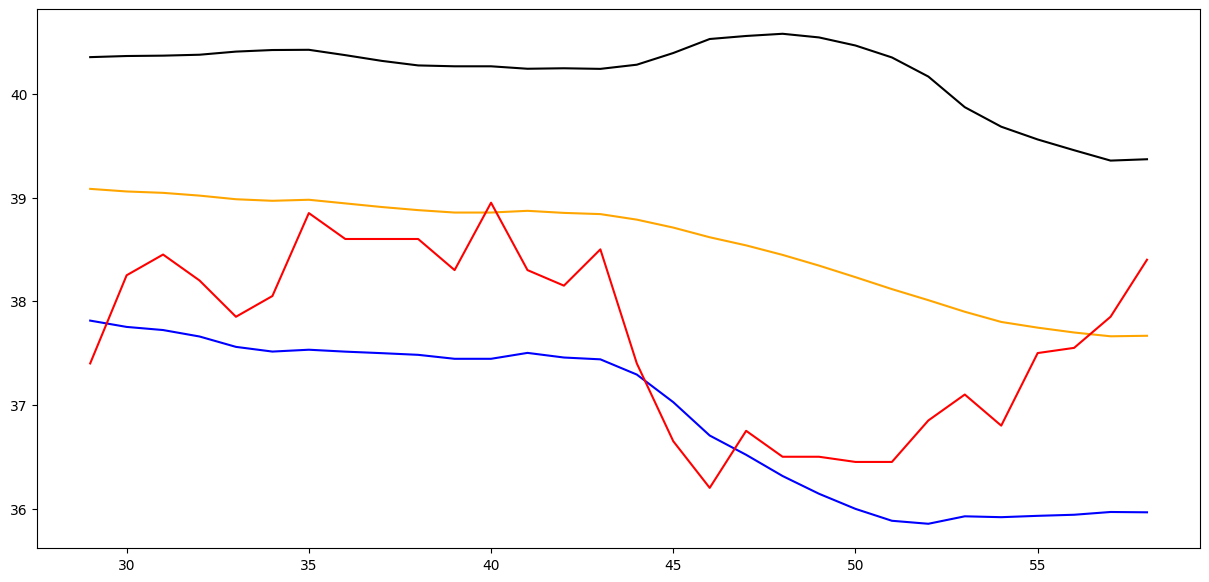

In [37]:
fig, ax = plt.subplots(figsize=(15,7))
sma30 = price_data['close'].rolling(30).mean()[29:]
sma30_std = price_data['close'].rolling(30).std()[29:]
upper_band = sma30+ 2*sma30_std
lower_band = sma30- 2*sma30_std
price = price_data['close'][29:]

upper_band[:30].plot(ax=ax, color='black')
lower_band[:30].plot(ax=ax, color='blue')
sma30[:30].plot(ax=ax, color='orange')
price[:30].plot(ax=ax, color='red')
# price_data['close'].rolling(30).mean()[120:200].plot(ax=ax, color='black')
# price_data['close'][120:200].plot(ax=ax, color='yellow')
# price_data['close'].rolling(120).mean()[120:200].plot(ax=ax, color='blue')



buy = price< lower_band
buy

sell = price > upper_band


profit = 